Take the points of the three microphones as M1, M2, and M3. The distance, defined as the variable `side_length`, shows how far away each microphone is from each other. In this case, they are 1 meter apart from each other. 

d1 (B to M1): 1.4142
d2 (B to M2): 1.0000
d3 (B to M3): 0.5176


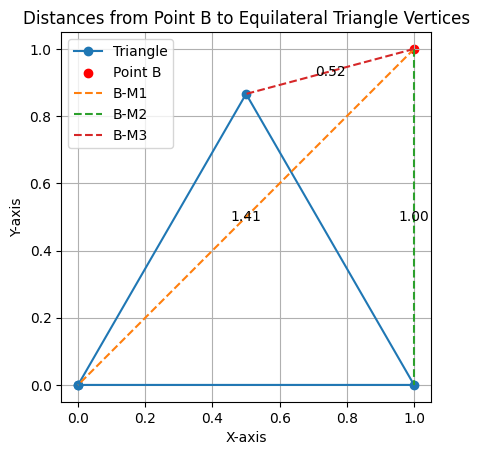

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the side length of the equilateral triangle
side_length = 1.0

# Define the vertices of the equilateral triangle
M1 = np.array([0.0, 0.0])
M2 = np.array([side_length, 0.0])
M3 = np.array([side_length / 2, side_length * np.sqrt(3) / 2])

# Define an arbitrary point B (adjust as needed)
B = np.array([1,1])

# Calculate distances from B to each vertex
distances = {
    'd1 (B to M1)': np.linalg.norm(B - M1),
    'd2 (B to M2)': np.linalg.norm(B - M2),
    'd3 (B to M3)': np.linalg.norm(B - M3),
}

# Print distances
for name, value in distances.items():
    print(f"{name}: {value:.4f}")

# Prepare the triangle and point for plotting
triangle_coords = np.vstack([M1, M2, M3, M1])  # Closed loop

# Create plot
fig, ax = plt.subplots()
ax.plot(triangle_coords[:, 0], triangle_coords[:, 1], linestyle='-', marker='o', label='Triangle')
ax.scatter(B[0], B[1], color='red', label='Point B')

# Draw lines from B to each vertex and annotate distances
for i, M in enumerate([M1, M2, M3], start=1):
    ax.plot([B[0], M[0]], [B[1], M[1]], linestyle='--', label=f'B-M{i}')
    mid_point = (B + M) / 2
    ax.text(mid_point[0], mid_point[1], f"{distances[f'd{i} (B to M{i})']:.2f}", 
            fontsize=10, ha='center', va='center')

# Finalize the plot
ax.set_aspect('equal', 'box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Distances from Point B to Equilateral Triangle Vertices')
ax.legend()
plt.grid(True)
plt.show()



The speed of sound is 343 meters per second. We are interested in the time delay between the beam and the three nodes. If we invert the speed of sound, we get how many seconds it takes for sound to travel 1 meter: $0.00292$ seconds, or $2.92$ milliseconds. As a result, since the Beam B is 0.52 meters from M3, we can conclude that it would take 1/343 m/s 0.52 meters = 1.516 milliseconds to reach M3. We can write a formula below. 

Signal tone generator. 

In [5]:
import numpy as np
import wave
import struct

# Parameters
fs = 44100          # Sampling frequency (Hz)
duration = 1.0      # Duration of the signal (seconds)
f0, f1 = 200, 200    # Start and end frequencies (Hz)

# Time vector
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Phase for linear frequency sweep: φ(t) = 2π ∫ f(t) dt = 2π (f0*t + (f1-f0)/(2*duration) * t^2)
phase = 2 * np.pi * (f0 * t + (f1 - f0) / (2 * duration) * t**2)

# Generate the signal
signal = np.sin(phase)

# Scale to 16-bit PCM
amplitude = 32767  # Maximum for int16
data = (signal * amplitude).astype(np.int16)

# Write to WAV file
filename = 'sound.wav'
with wave.open(filename, 'w') as wav_file:
    wav_file.setnchannels(1)        # Mono
    wav_file.setsampwidth(2)        # 2 bytes per sample
    wav_file.setframerate(fs)
    wav_file.writeframes(data.tobytes())

filename

'sound.wav'

We now run into problems regarding the limitations of the microphones themselves, inherently tied to the sampling rate. 

Here is the formula for the delay, in milliseconds, between any two pairs of microphones when they hear a beam:

$a\left(x\right)=\left|\cos\left(x\right)\right|\cdot\frac{D}{343}\cdot1000\left\{0\le x\le180\right\}$

D is the distance between any two pairs of microphones, 343 is the speed of sound, and 1000 converts it to milliseconds. 

With a D = 1, where each pair of microphones is separated by 1 m each (that's over 3 ft), we can find that the maximum achievable delay between two mics is 2.915 milliseconds. This is the best case scenario. 

It is likely that D will be less than 1, most likely just 10 centimeters apart from each other. With that, we can only achieve 0.2915 milliseconds delay between mics. This is the maximum, where the beam B is collinear with the two microphones. It doesn't get any better than this. 

Let's now examine the sample rate of the microphones. Given that each mic has a max sampling rate of around 44.1 kHz, we only have a maximum number of samples to use as defined by this function: $s_{amples}=\frac{S}{343}\cdot D$. If we compute this formula with $S=44100$ and $D = 0.1$, we get that we can only have a maximum delay of $12.85$ samples between microphones. That can be rounded down to 12 samples. That comes out to a delay of $0.272$ milliseconds of maximum delay. With our low sampling rate, we can only see in terms of $0.023$ millisecond intervals. How does this impact the final angle? We will see...

For our simulator, what we need is a formula that will turn our distance (which we already know in advance since we define it) into an integer number of delayed samples. We simply combine the distance calculator and convert to milliseconds and round to show how many samples of delay there are. 

Distances (m): {'M1': np.float64(10.0), 'M2': np.float64(9.0), 'M3': np.float64(9.539392014169456)}
Time delays (s): {'M1': np.float64(0.029154518950437316), 'M2': np.float64(0.026239067055393587), 'M3': np.float64(0.027811638525275382)}
Sample delays (# samples): {'M1': 5598, 'M2': 5038, 'M3': 5340}


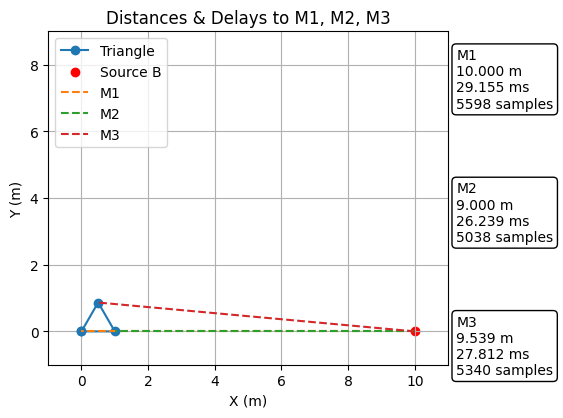

In [21]:
import numpy as np
import wave
import struct
import matplotlib.pyplot as plt

# Acoustic / sampling parameters
c = 343.0          # speed of sound (m/s)
fs = 192000        # sampling frequency (Hz)
duration = 1.0     # signal duration (s)

# Signal generation (200 Hz tone)
f0, f1 = 200, 200
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
phase = 2 * np.pi * (f0 * t + (f1 - f0) / (2 * duration) * t**2)
signal = np.sin(phase)

# --- Geometry: triangle vertices and source B ---
side_length = 1  # meters
M1 = np.array([0.0, 0.0])
M2 = np.array([side_length, 0.0])
M3 = np.array([side_length/2, side_length * np.sqrt(3)/2])
B  = np.array([10, 0])  # source location

# Compute distances (m), time-delays (s), and sample-delays (#)
distances = {
    'M1': np.linalg.norm(B - M1),
    'M2': np.linalg.norm(B - M2),
    'M3': np.linalg.norm(B - M3),
}
time_delays   = {mic: dist / c for mic, dist in distances.items()}
sample_delays = {mic: int(round(td * fs)) for mic, td in time_delays.items()}

print("Distances (m):", distances)
print("Time delays (s):", time_delays)
print("Sample delays (# samples):", sample_delays)

# Build delayed signals (for completeness; not used in the plot)
max_delay = max(sample_delays.values())
n_total   = max_delay + len(signal)
mic_signals = {}
for mic, delay in sample_delays.items():
    x = np.zeros(n_total)
    x[delay:delay + len(signal)] = signal
    mic_signals[mic] = x

# --- Plot geometry with annotated delays ---
triangle_coords = np.vstack([M1, M2, M3, M1])

fig, ax = plt.subplots()
ax.plot(triangle_coords[:, 0], triangle_coords[:, 1],
        linestyle='-', marker='o', label='Triangle')
ax.scatter(B[0], B[1], color='red', label='Source B')

# Draw lines to each mic
for mic, M in zip(['M1', 'M2', 'M3'], [M1, M2, M3]):
    ax.plot([B[0], M[0]], [B[1], M[1]],
            linestyle='--', label=mic)

# Set fixed axis size (10x10 meters area)
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 9)

# Make room on right
fig.subplots_adjust(right=0.75)

# Annotate info boxes on the side
box_height = 0.4
y_start = 0.95

for mic in ['M1', 'M2', 'M3']:
    info = (
        f"{mic}\n"
        f"{distances[mic]:.3f} m\n"
        f"{time_delays[mic]*1e3:.3f} ms\n"
        f"{sample_delays[mic]} samples"
    )
    ax.text(1.02, y_start, info, transform=ax.transAxes,
            fontsize=10, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    y_start -= box_height

ax.set_aspect('equal', 'box')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Distances & Delays to M1, M2, M3')
ax.legend(loc='upper left')
ax.grid(True)

plt.show()


In [ ]:
import numpy as np
import wave
import struct
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Acoustic / sampling parameters
c = 343.0          # speed of sound (m/s)
fs = 192000        # sampling frequency (Hz)
duration = 1.0     # signal duration (s)

# Generate a 200 Hz tone
f0, f1 = 200, 200
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
phase = 2 * np.pi * (f0 * t + (f1 - f0) / (2 * duration) * t**2)
signal = np.sin(phase)

# --- Geometry: triangle vertices and known source B ---
side_length = 10.0  # meters
M1 = np.array([0.0, 0.0])
M2 = np.array([side_length, 0.0])
M3 = np.array([side_length/2, side_length * np.sqrt(3)/2])
B  = np.array([10.0, 0.0])   # true source location (m)

# Compute true distances, time-delays, and integer sample-delays
distances     = {mic: np.linalg.norm(B - M) for mic, M in zip(['M1','M2','M3'], [M1,M2,M3])}
time_delays   = {mic: dist/c for mic, dist in distances.items()}
sample_delays = {mic: int(round(td * fs)) for mic, td in time_delays.items()}

print("Sample delays (in samples):", sample_delays)

# Print pairwise sample-difference
pairs = [('M2','M1'), ('M3','M1'), ('M3','M2')]
for a, b in pairs:
    diff = sample_delays[a] - sample_delays[b]
    print(f"Sample delay difference {a} - {b}: {diff} samples")

# Build the three delayed signals
max_delay = max(sample_delays.values())
n_total   = max_delay + len(signal)
mic_signals = {}
for mic, delay in sample_delays.items():
    buf = np.zeros(n_total)
    buf[delay:delay + len(signal)] = signal
    mic_signals[mic] = buf

# --- GCC-PHAT function (from gcc_phat.py) ---
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    n = sig.shape[0] + refsig.shape[0]
    SIG    = np.fft.rfft(sig,    n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R      = SIG * np.conj(REFSIG)
    cc     = np.fft.irfft(R/np.abs(R), n=(interp * n))
    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = min(int(interp * fs * max_tau), max_shift)
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))
    shift = np.argmax(np.abs(cc)) - max_shift
    tau = shift / float(interp * fs)
    return tau, cc

# --- Triangulation (3-mic) from tdoa_triangulation.py ---
def posError(pos, d_2diff1, d_3diff1, mic_positions):
    x, y = pos
    d1 = np.hypot(x - mic_positions[0][0], y - mic_positions[0][1])
    d2 = np.hypot(x - mic_positions[1][0], y - mic_positions[1][1])
    d3 = np.hypot(x - mic_positions[2][0], y - mic_positions[2][1])
    return (d2 - d1 - d_2diff1)**2 + (d3 - d1 - d_3diff1)**2

def triangulatePosition(audio, temp=68, mic_positions=None):
    if mic_positions is None:
        mic_positions = [[0.0,0.0], [1.0,0.0], [0.5,0.866]]
    # sound speed adjusted for Fahrenheit temp
    v_sound = 331 + 0.606 * ((temp - 32) * 5/9)
    (fs1, sig1), (fs2, sig2), (fs3, sig3) = audio
    tdoa_2d1 = gcc_phat(sig2, sig1, fs=fs1)[0]
    tdoa_3d1 = gcc_phat(sig3, sig1, fs=fs1)[0]
    d_2d1 = tdoa_2d1 * v_sound
    d_3d1 = tdoa_3d1 * v_sound

    result = minimize(
        posError,
        x0=[0,0],
        args=(d_2d1, d_3d1, mic_positions),
        method='Nelder-Mead',
        options={'maxiter':10000, 'xatol':1e-8, 'fatol':1e-8}
    )
    if not result.success:
        raise RuntimeError("Triangulation failed: " + result.message)
    return result.x

# Perform TDOA-based localization
audio_data = [
    (fs, mic_signals['M1']),
    (fs, mic_signals['M2']),
    (fs, mic_signals['M3'])
]
est_pos = triangulatePosition(audio_data, temp=68,
                              mic_positions=[M1.tolist(), M2.tolist(), M3.tolist()])

# --- Compare to ground truth ---
print("\nGround truth location:      ", B)
print("Estimated location:         ", est_pos)

# Position error
pos_error = np.linalg.norm(est_pos - B)
print(f"Position error:             {pos_error:.3f} m")

# Compute bearing from triangle centroid
centroid      = (M1 + M2 + M3) / 3
true_bearing  = np.degrees(np.arctan2(B[1]-centroid[1], B[0]-centroid[0]))
est_bearing   = np.degrees(np.arctan2(est_pos[1]-centroid[1], est_pos[0]-centroid[0]))
angle_error   = est_bearing - true_bearing

print(f"True bearing:              {true_bearing:.2f}°")
print(f"Estimated bearing:         {est_bearing:.2f}°")
print(f"Angular error:             {angle_error:.2f}°")


Sample delays (in samples): {'M1': 55977, 'M2': 50379, 'M3': 53398}
Sample delay difference M2 - M1: -5598 samples
Sample delay difference M3 - M1: -2579 samples
Sample delay difference M3 - M2: 3019 samples

Ground truth location:       [10.  0.]
Estimated location:          [1.00684836e+01 2.31374833e-07]
Position error:             0.068 m
True bearing:              -1.74°
Estimated bearing:         -1.73°
Angular error:             0.01°


Here we will run simulations, testing various different side lengths and sampling rates and comparing its error to the ground truth. 

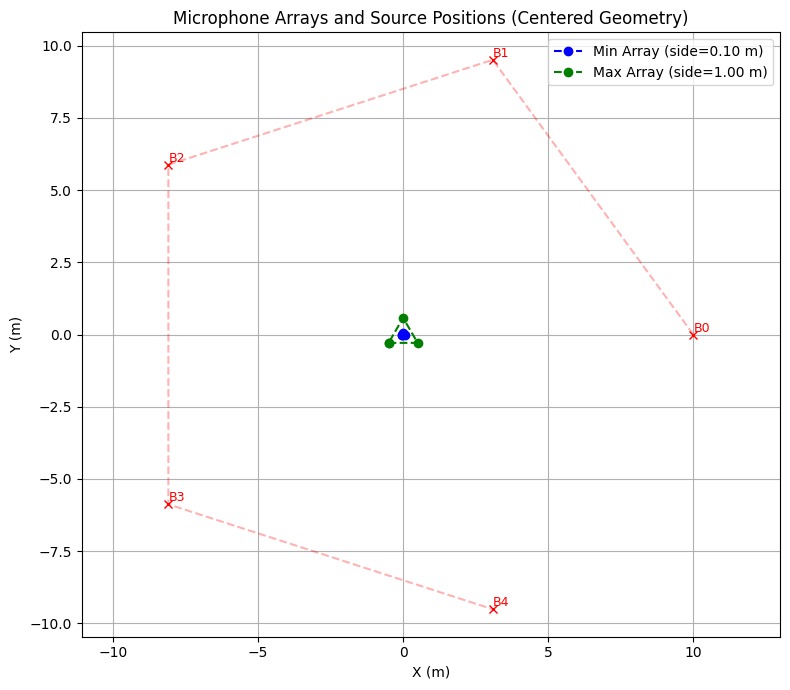

/var/folders/9h/98h9kx950dd15q3x8k8zbj1c0000gn/T/ipykernel_67417/3698298003.py:14: RuntimeWarning: invalid value encountered in divide
  cc = np.fft.irfft(R / np.abs(R), n=(interp * n))



=== Results for sampling rate: 24000 Hz ===
 side_length      B_x       B_y      pos_err    ang_err
    0.100000 10.00000  0.000000 9.477291e+00  -3.160780
    0.100000  3.09017  9.510565 9.833203e+00  -2.040126
    0.100000 -8.09017  5.877853 2.355545e+06  -0.402111
    0.100000 -8.09017 -5.877853 9.948838e+00   9.045178
    0.100000  3.09017 -9.510565 2.334945e+06  -2.177774
    0.118367 10.00000  0.000000 9.804475e+00   4.660432
    0.118367  3.09017  9.510565 7.700607e+00   3.816729
    0.118367 -8.09017  5.877853 9.780559e+00  -0.146081
    0.118367 -8.09017 -5.877853 9.926554e+00   5.561726
    0.118367  3.09017 -9.510565 9.587584e+00   1.732506
    0.136735 10.00000  0.000000 9.853826e+00   3.082309
    0.136735  3.09017  9.510565 9.735255e+00  -3.441582
    0.136735 -8.09017  5.877853 4.582316e+06   0.677554
    0.136735 -8.09017 -5.877853 9.921746e+00   4.416995
    0.136735  3.09017 -9.510565 9.650491e+00  -1.392418
    0.155102 10.00000  0.000000 8.522497e+00  -1.735616
   

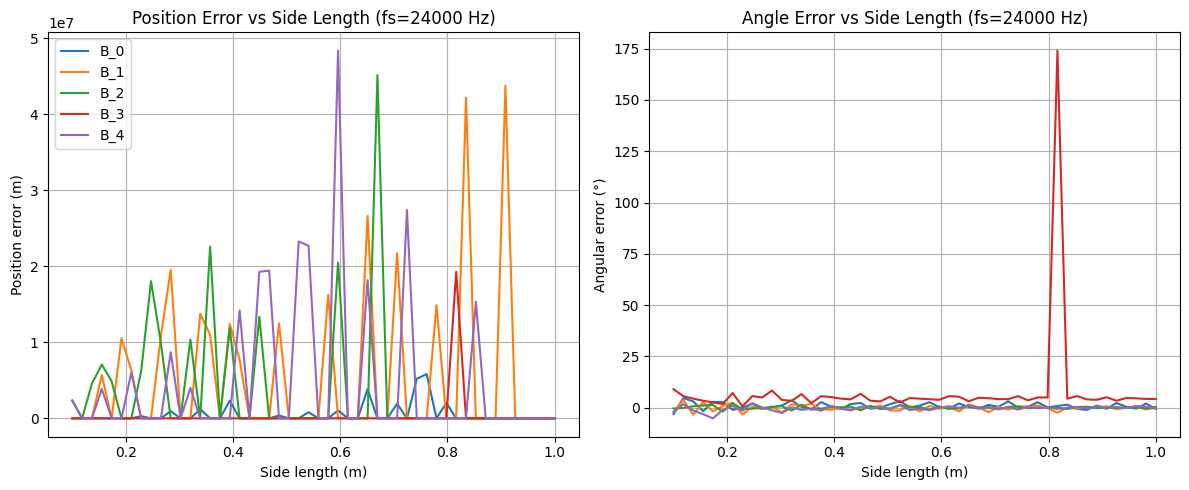


=== Results for sampling rate: 44100 Hz ===
 side_length      B_x       B_y      pos_err   ang_err
    0.100000 10.00000  0.000000 8.876714e+00 -1.472067
    0.100000  3.09017  9.510565 2.985276e+06  0.468436
    0.100000 -8.09017  5.877853 3.895804e+06 -2.947091
    0.100000 -8.09017 -5.877853 9.944790e+00  1.899832
    0.100000  3.09017 -9.510565 2.834825e+06 -0.815033
    0.118367 10.00000  0.000000 9.752743e+00  1.623167
    0.118367  3.09017  9.510565 9.511941e+00  1.607938
    0.118367 -8.09017  5.877853 9.627690e+00  2.525877
    0.118367 -8.09017 -5.877853 9.933221e+00  7.170695
    0.118367  3.09017 -9.510565 3.904399e+06  1.079439
    0.136735 10.00000  0.000000 4.310805e+05  0.768325
    0.136735  3.09017  9.510565 3.246429e+06  1.551820
    0.136735 -8.09017  5.877853 7.694628e+00 -0.423666
    0.136735 -8.09017 -5.877853 9.925298e+00  5.602858
    0.136735  3.09017 -9.510565 9.376815e+00  0.834501
    0.155102 10.00000  0.000000 6.256779e+05  0.096337
    0.155102  3.0901

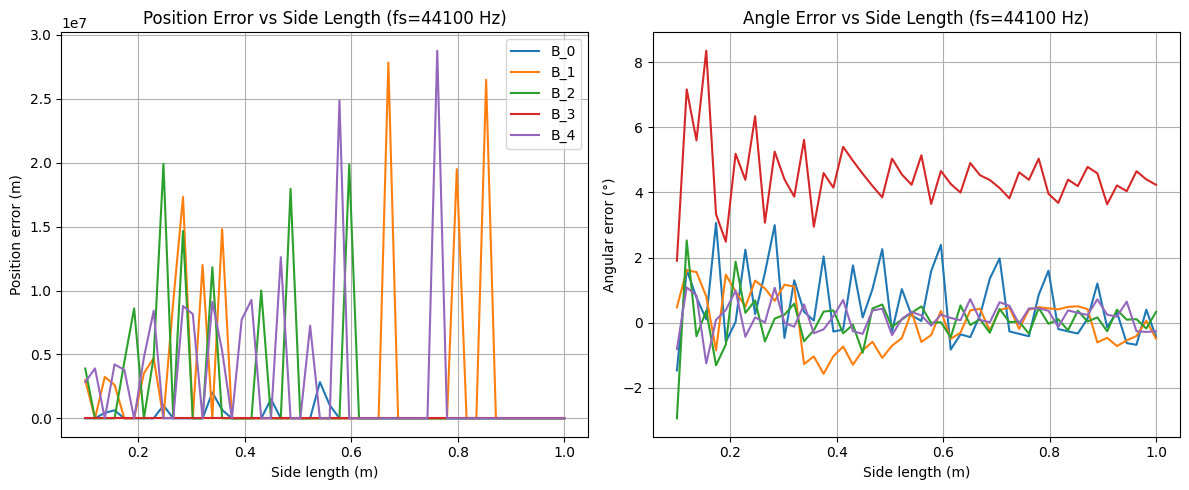


=== Results for sampling rate: 48000 Hz ===
 side_length      B_x       B_y      pos_err    ang_err
    0.100000 10.00000  0.000000 8.403696e+04   0.013794
    0.100000  3.09017  9.510565 1.959418e+06   2.013794
    0.100000 -8.09017  5.877853 9.680946e+00   2.217769
    0.100000 -8.09017 -5.877853 9.945391e+00   1.299359
    0.100000  3.09017 -9.510565 1.081048e+06   2.546355
    0.118367 10.00000  0.000000 2.487442e+06   2.801708
    0.118367  3.09017  9.510565 9.685801e+00  -5.789651
    0.118367 -8.09017  5.877853 9.001178e+00  -0.710633
    0.118367 -8.09017 -5.877853 9.935486e+00   6.323744
    0.118367  3.09017 -9.510565 2.127636e+06  -1.853565
    0.136735 10.00000  0.000000 9.333758e+00   3.405593
    0.136735  3.09017  9.510565 9.392014e+00  -1.541467
    0.136735 -8.09017  5.877853 9.307152e+00   0.310938
    0.136735 -8.09017 -5.877853 9.921746e+00   4.416995
    0.136735  3.09017 -9.510565 5.870820e+06  -0.128890
    0.155102 10.00000  0.000000 9.708191e+00   5.661417
   

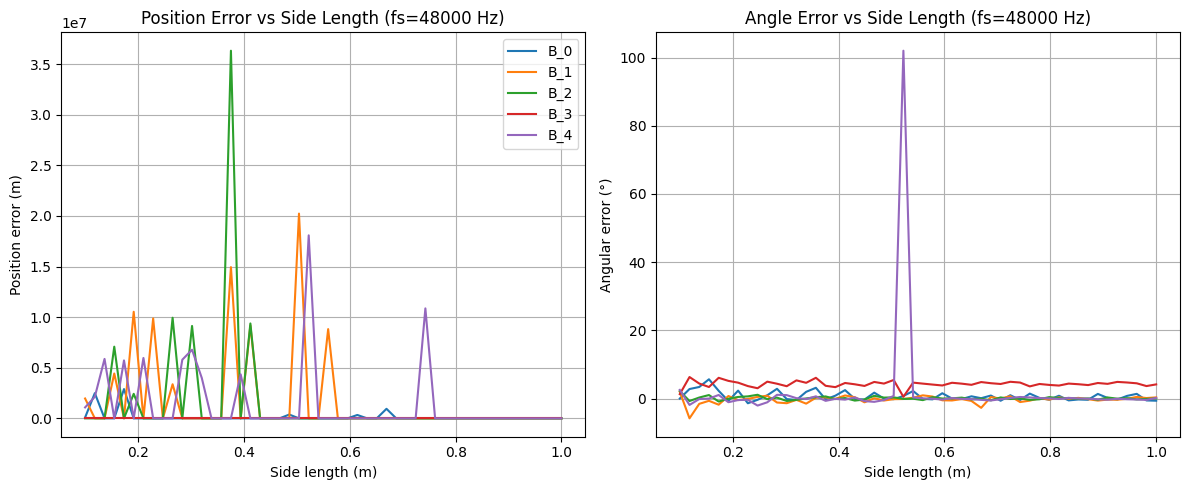


=== Results for sampling rate: 192000 Hz ===
 side_length      B_x       B_y      pos_err   ang_err
    0.100000 10.00000  0.000000 8.403696e+04  0.013794
    0.100000  3.09017  9.510565 5.879173e+00 -0.887760
    0.100000 -8.09017  5.877853 6.594922e+00 -0.101811
    0.100000 -8.09017 -5.877853 9.945544e+00  4.954421
    0.100000  3.09017 -9.510565 9.290864e+00 -0.985587
    0.118367 10.00000  0.000000 9.419532e+00  1.672748
    0.118367  3.09017  9.510565 7.983864e+00  0.131153
    0.118367 -8.09017  5.877853 7.446503e+06  0.104426
    0.118367 -8.09017 -5.877853 9.936178e+00  4.853345
    0.118367  3.09017 -9.510565 2.780474e+06  0.443920
    0.136735 10.00000  0.000000 4.547969e+00 -0.155457
    0.136735  3.09017  9.510565 3.630463e+00 -0.326354
    0.136735 -8.09017  5.877853 9.119363e+06  0.026219
    0.136735 -8.09017 -5.877853 9.925267e+00  4.663185
    0.136735  3.09017 -9.510565 3.246221e+06  0.251888
    0.155102 10.00000  0.000000 2.301994e+00 -0.208536
    0.155102  3.090

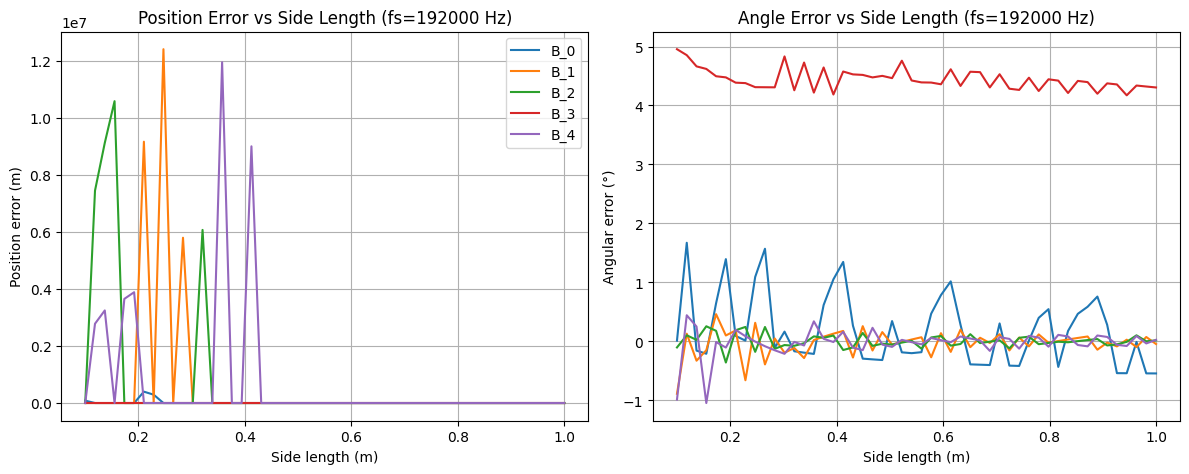

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import concurrent.futures

# --- Reusable functions ----------------------------------------------------

def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    n = sig.shape[0] + refsig.shape[0]
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)
    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))
    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = min(int(interp * fs * max_tau), max_shift)
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))
    shift = np.argmax(np.abs(cc)) - max_shift
    return shift / float(interp * fs)

def posError(pos, d21, d31, mic_positions):
    x, y = pos
    d1 = np.hypot(x - mic_positions[0][0], y - mic_positions[0][1])
    d2 = np.hypot(x - mic_positions[1][0], y - mic_positions[1][1])
    d3 = np.hypot(x - mic_positions[2][0], y - mic_positions[2][1])
    return (d2 - d1 - d21)**2 + (d3 - d1 - d31)**2

def triangulatePosition(audio, mic_positions):
    v_sound = 343.0
    (fs1, sig1), (fs2, sig2), (fs3, sig3) = audio
    tau21 = gcc_phat(sig2, sig1, fs=fs1)
    tau31 = gcc_phat(sig3, sig1, fs=fs1)
    d21 = tau21 * v_sound
    d31 = tau31 * v_sound
    res = minimize(posError,
                   x0=[0, 0],
                   args=(d21, d31, mic_positions),
                   method='Nelder-Mead',
                   options={'maxiter': 10000, 'xatol': 1e-8, 'fatol': 1e-8})
    if not res.success:
        raise RuntimeError("Triangulation failed")
    return np.array(res.x)

# --- Triangle centered at origin --------------------------------------------

def triangle_coords_centered(sl):
    h = sl * np.sqrt(3)/2
    M1 = np.array([-sl/2, -h/3])
    M2 = np.array([ sl/2, -h/3])
    M3 = np.array([   0.0,  2*h/3])
    return np.vstack([M1, M2, M3, M1]), [M1, M2, M3]

# --- Simulation wrapper -----------------------------------------------------

def simulate(args):
    side_length, fs, B = args

    # generate tone
    duration = 1.0
    f0, f1 = 200, 200
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    phase = 2*np.pi*(f0*t + (f1-f0)/(2*duration)*t**2)
    signal = np.sin(phase)

    # triangle geometry
    _, mics = triangle_coords_centered(side_length)
    mic_positions = [m.tolist() for m in mics]

    # compute delays
    distances = [np.linalg.norm(B - M) for M in mics]
    time_delays = [d/343.0 for d in distances]
    sample_delays = [int(round(td * fs)) for td in time_delays]

    # build audio
    max_d = max(sample_delays)
    buf_len = max_d + len(signal)
    audio = []
    for sd in sample_delays:
        buf = np.zeros(buf_len)
        buf[sd:sd+len(signal)] = signal
        audio.append((fs, buf))

    # localize
    est = triangulatePosition(audio, mic_positions)

    # error
    pos_err = np.linalg.norm(est - B)
    centroid = np.mean(mics, axis=0)
    true_bear = np.degrees(np.arctan2(B[1] - centroid[1], B[0] - centroid[0]))
    est_bear  = np.degrees(np.arctan2(est[1] - centroid[1], est[0] - centroid[0]))
    ang_err = est_bear - true_bear

    return {
        'side_length': side_length,
        'fs': fs,
        'B_x': B[0],
        'B_y': B[1],
        'pos_err': pos_err,
        'ang_err': ang_err
    }

# --- Parameters -------------------------------------------------------------

side_lengths = np.linspace(0.1, 1.0, 50)
sampling_rates = [24000, 44100, 48000, 192000]
R = 10.0
angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
B_coords_final = [R * np.array([np.cos(a), np.sin(a)]) for a in angles]

# Simulation tasks
tasks = []
for sl in side_lengths:
    for fs in sampling_rates:
        for B in B_coords_final:
            tasks.append((sl, fs, B))

# --- Final Geometry Plot ----------------------------------------------------

min_triangle, _ = triangle_coords_centered(min(side_lengths))
max_triangle, _ = triangle_coords_centered(max(side_lengths))

plt.figure(figsize=(8, 7))
plt.plot(min_triangle[:, 0], min_triangle[:, 1], 'b--o', label=f'Min Array (side={min(side_lengths):.2f} m)')
plt.plot(max_triangle[:, 0], max_triangle[:, 1], 'g--o', label=f'Max Array (side={max(side_lengths):.2f} m)')

for i, B in enumerate(B_coords_final):
    plt.plot(B[0], B[1], 'rx')
    plt.text(B[0], B[1], f'B{i}', fontsize=9, ha='left', va='bottom', color='red')

plt.plot([pt[0] for pt in B_coords_final],
         [pt[1] for pt in B_coords_final], 'r--', alpha=0.3)

plt.title('Microphone Arrays and Source Positions (Centered Geometry)')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# --- Simulation Execution ---------------------------------------------------

with concurrent.futures.ThreadPoolExecutor() as pool:
    results = list(pool.map(simulate, tasks))

df = pd.DataFrame(results)

# --- Output & Plots ---------------------------------------------------------

for fs in sampling_rates:
    df_fs = df[df['fs'] == fs]
    print(f"\n=== Results for sampling rate: {fs} Hz ===")
    print(df_fs[['side_length', 'B_x', 'B_y', 'pos_err', 'ang_err']].to_string(index=False))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    for i, angle in enumerate(angles):
        Bx = R * np.cos(angle)
        By = R * np.sin(angle)
        df_B = df_fs[np.isclose(df_fs['B_x'], Bx) & np.isclose(df_fs['B_y'], By)]
        label = f"B_{i}"
        ax1.plot(df_B['side_length'], df_B['pos_err'], label=label)
        ax2.plot(df_B['side_length'], df_B['ang_err'], label=label)

    ax1.set_title(f"Position Error vs Side Length (fs={fs} Hz)")
    ax1.set_xlabel("Side length (m)")
    ax1.set_ylabel("Position error (m)")
    ax1.grid(True)
    ax1.legend()

    ax2.set_title(f"Angle Error vs Side Length (fs={fs} Hz)")
    ax2.set_xlabel("Side length (m)")
    ax2.set_ylabel("Angular error (°)")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
